In [4]:
from utilities.data_functions import col_to_edge_list, chromatic_numbers
from utilities.vis_helpers import plot_coloring
from algorithms.color_gcn import ColorGCN
import torch
import torch.optim as optim
from utilities.eval import WangLoss, PottsLoss, count_collisions, get_bad_edges
from utilities.helpers import get_device

device = get_device()
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 4090


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
#         deg = torch.sum(adj, dim=1)
#         out /= deg.view(-1, 1)
        out = self.W(out)
        return out



class ColorGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super().__init__()
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.layers.append(GraphConvolution(input_dim, hidden_dim))

        for _ in range(num_layers - 2):
            self.layers.append(GraphConvolution(hidden_dim, hidden_dim))

        self.layers.append(GraphConvolution(hidden_dim, output_dim))

        self.adj_normalized = None

    def forward(self, x, edge_index):
        if self.adj_normalized is None:
            self._make_adj(edge_index)

        for i, layer in enumerate(self.layers):
            x = layer(x, self.adj_normalized)
            # Apply activation and dropout for all layers except the last one
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.softmax(x, dim=1)
        return x

    def _make_adj(self, edge_index):
        # Create the adjacency matrix from an edge index
        adj = to_dense_adj(edge_index).squeeze(0)

        # Add self-loops and normalize the adjacency matrix
#         adj = adj + torch.eye(adj.size(0)).to(adj.device)
#         D = torch.diag(torch.sum(adj, dim=1) ** (-0.5))
#         self.adj_normalized = torch.matmul(torch.matmul(D, adj), D)
        self.adj_normalized = adj
        self.adj_normalized = self.adj_normalized.to(edge_index.device)

        

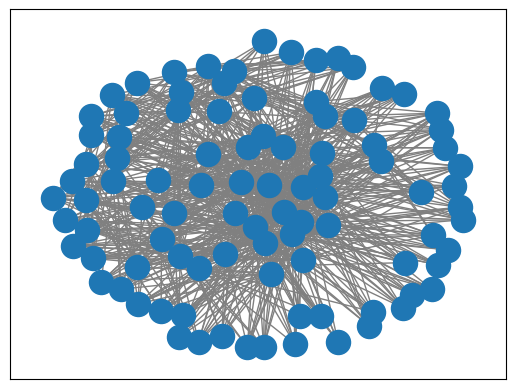

In [6]:
# Load and plot the graph

graph = 'myciel6.col'
n, edge_list, col_list = col_to_edge_list(f'data/input/COLOR/instances/{graph}')
plot_coloring(edge_list)

In [7]:
import pandas as pd
from tqdm.notebook import tqdm

# Run the graph model
best_coloring = None
fewest_collisions = 10e5
results = []
cols = ['input_dim', 'hidden_dim', 'dropout', 'use_embedding', 'lr', 'collisions']
patience = 1000

for in_dim in tqdm([16], desc='in_dim'):
    for hid_dim in tqdm([64, 128], desc='hid_dim', leave=False):
        for dropout in tqdm([0.1, 0.2, 0.3], desc='dropout', leave=False):
            for use_embedding in tqdm([True, False], desc='use_embedding', leave=False):
                for lr in tqdm([5e-4, 1e-3, 5e-3], desc='lr', leave=False):
                    input_dim = in_dim
                    hidden_dim = hid_dim
                    output_dim = chromatic_numbers[graph]
                    num_layers = 1
                    epochs = 100000

                    model = ColorGCN(input_dim, hidden_dim, output_dim, num_layers, dropout=dropout).to(device)
                    edge_index = edge_list.to(device)
                    if use_embedding:
                        embeddings = nn.Embedding(n, input_dim).to(device)
                        graph_nodes = torch.arange(n).long().to(device)
                    else:
                        graph_rep = torch.randn((n, input_dim)).to(device)
                    if use_embedding:
                        optimizer = optim.Adam(list(model.parameters()) + list(embeddings.parameters()), lr=lr)
                    else:
                        optimizer = optim.Adam(model.parameters(), lr=lr)
                    loss_fn = PottsLoss(edge_index)
#                     loss_fn = WangLoss(edge_index, lam=.02)

                    prev_loss = 10e5
                    last_improvement = 0
                    for i in range(epochs):
                        if last_improvement > patience:
                            break
                        model.train()
                        optimizer.zero_grad()
                        if use_embedding:
                            graph_rep = embeddings(graph_nodes)
                        out = model(graph_rep, edge_index)
                        loss = loss_fn(out)
                        loss.backward()
                        optimizer.step()
                        if loss < prev_loss:
                            prev_loss = loss
                            last_improvement = 0
                        else:
                            last_improvement += 1
                        if i % 1000 == 0:
                            model.eval()
                            with torch.no_grad():
                                out = model(graph_rep, edge_list)
                            coloring = torch.argmax(out, dim=1)
                            collisions = count_collisions(coloring, edge_list)
                            # print(f'{i}: {collisions, loss}')
                            if collisions == 0:
                                best_coloring = coloring
                                break
                            if collisions < fewest_collisions:
                                fewest_collisions = collisions
                                best_coloring = coloring

                    model.eval()
                    with torch.no_grad():
                        out = model(graph_rep, edge_list)
                    coloring = torch.argmax(out, dim=1)
                    collisions = count_collisions(coloring, edge_list)
                    results.append([in_dim, hid_dim, dropout, use_embedding, lr, collisions])



in_dim:   0%|          | 0/1 [00:00<?, ?it/s]

hid_dim:   0%|          | 0/2 [00:00<?, ?it/s]

dropout:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

dropout:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

0.0


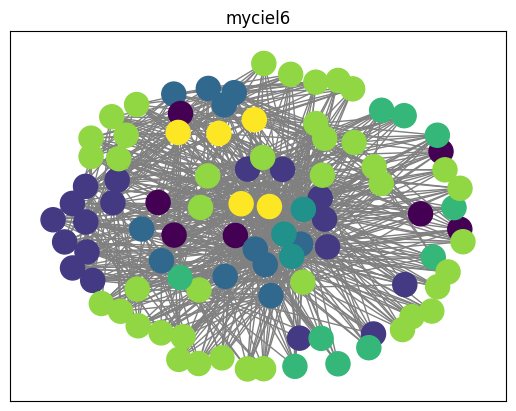

In [8]:
# Plot the colored graph
# 6_6: 1, 7_7: 6, 8_8: 5, 11_11: 26
bad_edges = get_bad_edges(best_coloring, edge_list)
print(len(bad_edges)/2)
plot_coloring(edge_list.cpu(), best_coloring.cpu(), bad_edges=bad_edges, title=graph.split('.')[0])


In [92]:
import pandas as pd
df_results = pd.DataFrame(results, columns=cols)

In [93]:
df_results.groupby('lr').mean()

,input_dim,hidden_dim,dropout,use_embedding,collisions
lr,,,,,
0.0005,16.0,96.0,0.2,0.5,99.083333
0.0010,16.0,96.0,0.2,0.5,136.416667
0.0050,16.0,96.0,0.2,0.5,137.916667


In [94]:
df_results[df_results.collisions==26]

,input_dim,hidden_dim,dropout,use_embedding,lr,collisions
25,16,128,0.2,True,0.001,26.0


In [10]:
df_results

,input_dim,hidden_dim,dropout,use_embedding,lr,collisions
0,16,64,0.1,True,0.0005,74.0
1,16,64,0.1,True,0.0010,88.0
2,16,64,0.1,True,0.0050,82.0
3,16,64,0.1,False,0.0005,76.0
4,16,64,0.1,False,0.0010,66.0
5,16,64,0.1,False,0.0050,78.0
6,16,64,0.2,True,0.0005,88.0
7,16,64,0.2,True,0.0010,78.0
8,16,64,0.2,True,0.0050,88.0
9,16,64,0.2,False,0.0005,82.0


In [50]:
input_dim = 128
hidden_dim = 64
output_dim = chromatic_numbers[graph]
num_layers = 1
dropout = 0.1
epochs = 100000

model = ColorGCN(input_dim, hidden_dim, output_dim, num_layers, dropout=dropout).to(device)
edge_index = edge_list.to(device)
if use_embedding:
    embeddings = nn.Embedding(n, input_dim).to(device)
    graph_nodes = torch.arange(n).long().to(device)
else:
    graph_rep = torch.randn((n, input_dim)).to(device)
if use_embedding:
    optimizer = optim.Adam(list(model.parameters()) + list(embeddings.parameters()), lr=lr)
else:
    optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = PottsLoss(edge_index)
#                     loss_fn = WangLoss(edge_index, lam=.02)

prev_loss = 10e5
last_improvement = 0
for i in range(epochs):
    if last_improvement > patience:
        break
    model.train()
    optimizer.zero_grad()
    if use_embedding:
        graph_rep = embeddings(graph_nodes)
    out = model(graph_rep, edge_index)
    loss = loss_fn(out)
    loss.backward()
    optimizer.step()
    if loss < prev_loss:
        prev_loss = loss
        last_improvement = 0
    else:
        last_improvement += 1
    if i % 1000 == 0:
        model.eval()
        with torch.no_grad():
            out = model(graph_rep, edge_list)
        coloring = torch.argmax(out, dim=1)
        collisions = count_collisions(coloring, edge_list)
        # print(f'{i}: {collisions, loss}')
        if collisions == 0:
            best_coloring = coloring
            break
        if collisions < fewest_collisions:
            fewest_collisions = collisions
            best_coloring = coloring

model.eval()
with torch.no_grad():
    out = model(graph_rep, edge_list)
coloring = torch.argmax(out, dim=1)
collisions = count_collisions(coloring, edge_list)


8.0


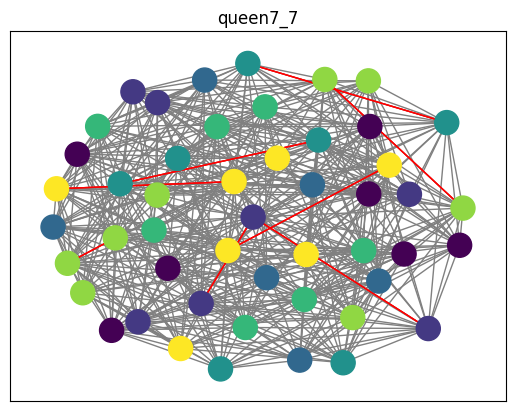

In [51]:
# Plot the colored graph
# 6_6: 1, 7_7: 8, 8_8: 5
bad_edges = get_bad_edges(best_coloring, edge_list)
print(len(bad_edges)/2)
plot_coloring(edge_list.cpu(), best_coloring.cpu(), bad_edges=bad_edges, title=graph.split('.')[0])

In [64]:
torch.trace(model.adj_normalized)

tensor(0., device='cuda:0')